## Rebuild the parametrized circuit in AWS Braket

In [55]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector
from qiskit.primitives import BackendEstimator, Estimator, Sampler, BackendSampler
from qiskit.quantum_info import SparsePauliOp

from braket.devices import LocalSimulator
from braket.circuits import Circuit, Gate, Instruction, QubitSet, AngledGate, Observable, noises, Noise
from braket.circuits.noise_model import GateCriteria, NoiseModel, NoiseModelInstruction
from braket.circuits.gates import X, Y, Z, Rx, Rz, CNot, XY, PulseGate, U, XX, ZZ
from braket.quantum_information import PauliString
from braket.parametric import FreeParameter, FreeParameterExpression
from braket.circuits.observables import TensorProduct

from qiskit_braket_provider.providers import adapter
from qiskit_braket_provider import AWSBraketProvider


In [56]:
# import numpy as np
# import sys
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
# module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

# # from template_configurations import gate_q_env_config
# # from quantumenvironment import QuantumEnvironment
# # from gymnasium.wrappers import RescaleAction, ClipAction

# import logging
# logging.basicConfig(
#     level=logging.WARNING,
#     format="%(asctime)s INFO %(message)s", # hardcoded INFO level
#     datefmt="%Y-%m-%d %H:%M:%S",
#     stream=sys.stdout,
# )

# from aws_estimator import AWSEstimator

In [57]:
action_vector = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]) # np.random.uniform(-np.pi, np.pi, 7)

Qiskit implementation of ``parametrized_circuit``

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


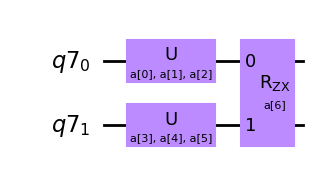

In [58]:
q_reg = QuantumRegister(2)
baseline = np.pi * np.zeros(len(action_vector))
params = ParameterVector("a", 7)
qiskit_circuit = QuantumCircuit(q_reg, name="custom_cx")
# optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
optimal_params = np.pi * np.zeros(7)

qiskit_circuit.u(
    baseline[0] + params[0],
    baseline[1] + params[1],
    baseline[2] + params[2],
    q_reg[0],
)
qiskit_circuit.u(
    baseline[3] + params[3],
    baseline[4] + params[4],
    baseline[5] + params[5],
    q_reg[1],
)

qiskit_circuit.rzx(baseline[6] + params[6], q_reg[0], q_reg[1])
qiskit_circuit.draw("mpl")

Conversion of Qiskit circuit to Braket circuit

In [59]:
braket_circuit_converted = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)

print(braket_circuit_converted)

T  : |       0        |1|2|   3   |4|5|
                                       
q0 : -U(a_0, a_1, a_2)---C---------C---
                         |         |   
q1 : -U(a_3, a_4, a_5)-H-X-Rz(a_6)-X-H-

T  : |       0        |1|2|   3   |4|5|

Unassigned parameters: [a_0, a_1, a_2, a_3, a_4, a_5, a_6].


In [60]:
braket_circuit_converted.parameters

{a_0, a_1, a_2, a_3, a_4, a_5, a_6}

### AWSEstimator

In [61]:
from typing import List, Union, Optional

In [108]:
class BraketEstimator:
    def __init__(self, backend):
        self.backend = backend

    def _validate_inputs(self, circuit, bound_parameters):
        """
        Validate the inputs to ensure the number of circuits matches the number of bound_parameters.

        :param circuit: A single QuantumCircuit or a list of QuantumCircuits.
        :param bound_parameters: A single dictionary of parameters or a list of dictionaries.
        :raises ValueError: If the number of circuits and parameter dictionaries do not match.
        """
        # Check if inputs are lists; if not, wrap them in a list
        if not isinstance(circuit, list):
            circuit = [circuit]
        if not isinstance(bound_parameters, list):
            bound_parameters = [bound_parameters]

        # Check if the number of circuits matches the number of parameter dictionaries
        if len(circuit) != len(bound_parameters):
            raise ValueError("The number of circuits must match the number of dictionaries of bound parameters.")
        
    def _validate_observable_string(self, obs_str: str):
        """
        Validate the input string for the observable.

        :param obs_str: The input string for the observable.
        :raises ValueError: If the input string is not a valid Pauli string.
        """
        if not all(char in ["X", "Y", "Z", "I"] for char in obs_str):
            raise ValueError("The observable string must be a valid Pauli string. Use only 'X', 'Y', 'Z', and 'I' characters.")

        
    def _post_process(self, result, observables, coefficients=None):
        """
        Process the result from the quantum computation to extract and optionally scale the expectation values.

        :param result: The result object returned by the quantum computation.
        :param observables: A list of observables for which the expectation values were measured.
        :param coefficients: Optional list of coefficients to scale the expectation values of the observables.
                            This should be in the same order as the observables list.
        :return: A list of processed expectation values.
        """
        if not isinstance(result, list):
            expectation_values = []

            # If coefficients are provided, they must match the number of observables
            if coefficients and len([observables]) != len([coefficients]):
                raise ValueError("The number of coefficients must match the number of observables.")

            for i, observable in enumerate([observables]):
                # Extract the raw expectation value from the result object
                raw_expectation_value = result.values[i]  # Assuming result.values is a list of expectation values
            
                # Apply the coefficient if provided, else use the raw value
                if coefficients:
                    coefficients = [coefficients] if not isinstance(coefficients, list) else coefficients   
                    processed_value = coefficients[i] * raw_expectation_value
                else:
                    processed_value = raw_expectation_value

                expectation_values.append(processed_value)

            return expectation_values
        
        elif isinstance(result, list) and len(result) > 1:
            expectation_values = []
            for res in result:
                expectation_values.append(self._post_process(res, observables, coefficients))
            return expectation_values
        
    def post_process(self, result, coefficients=None):
        """
        Calculate the weighted sum of the expectation values.
        """
        if coefficients is None:
            coefficients = [1.0] * len(result.values)

        # Calculate the weighted sum of the expectation values
        total_expectation = sum(coeff * result.values[0] for coeff, result in zip(coefficients, result))
        return total_expectation
    
    @staticmethod
    def _commutator(op1, op2):
        return op1@op2 == op2@op1
    
    def _group_observables(self, observables):
        groups = []
        for obs in observables:
            if isinstance(obs, str):
                    self._validate_observable_string(obs)
                    obs = PauliString(obs).to_unsigned_observable(include_trivial=True)
            placed = False
            for group in groups:
                if all(self._commutator(obs, member) for member in group):
                    group.append(obs)
                    placed = True
                    break
            if not placed:
                groups.append([obs])
        return groups


    def run(
        self, 
        circuit: Union[Circuit, list[Circuit]], 
        observables: Union[Observable, str, list[Observable], list[str]] = None,
        op_coefficients: Union[complex, list[complex]] = [1.0],
        target_register: Union[int, list[int]] = [0],
        bound_parameters: Optional[dict] = None,
        shots: int = 0, 
    ):

        self._validate_inputs(circuit, bound_parameters)

        if isinstance(observables, list):
            assert len(observables) == len(op_coefficients), "The number of observables must match the number of coefficients."
            op_coefficients = [1.0] * len(observables) if op_coefficients is None else op_coefficients
            # Group observables to minimize the number of circuits
            observable_groups = self._group_observables(observables=observables)
                        
            hamiltonian_results = []
            for group in observable_groups:
                # Make a copy of the original circuit for each group
                circ = circuit.copy() if isinstance(circuit, Circuit) else [c.copy() for c in circuit]

                for obs in group:
                    # Convert string observables to the Observable type if necessary
                    if not isinstance(obs, str) and not isinstance(obs, Observable) and not isinstance(obs, TensorProduct):
                        raise ValueError("Passed Observables can only be of type str, Observable or TensorProduct.")
                    if isinstance(obs, str):
                        self._validate_observable_string(obs)
                        obs = PauliString(obs).to_unsigned_observable(include_trivial=True)

                    # Use a dummy variable to avoid modifying the original circuit
                    # Add the expectation instruction to the circuit for each observable
                    circ = circuit.copy() if isinstance(circuit, Circuit) else [c.copy() for c in circuit]
                    circ.expectation(observable=obs, target=target_register)

                    if circuit.parameters: # Run with bound parameters if they exist
                        job = self.backend.run(circ, inputs=bound_parameters, shots=shots)
                    else:
                        job = self.backend.run(circ, shots=shots)

                    hamiltonian_results.append(job.result())

            hamiltonian_expval = self.post_process(hamiltonian_results, op_coefficients)
            return hamiltonian_results, np.array(hamiltonian_expval)

        elif isinstance(circuit, list) and len(circuit) > 1: # Batch execution
            if isinstance(observables, str):
                self._validate_observable_string(obs)
                observables = PauliString(observables).to_unsigned_observable(include_trivial=True)
            for circ in circuit:
                circ.expectation(observable=observables, target=target_register)
            
            print('Running batch...')
            job = self.backend.run_batch(circuit, inputs=bound_parameters, shots=shots)
            print('Finished running batch.')
            
            return list(job.results()), self._post_process(list(job.results()), observables, op_coefficients)
        
        else:
            if isinstance(observables, str):
                self._validate_observable_string(obs)
                observables = PauliString(observables).to_unsigned_observable(include_trivial=True)
            circuit.expectation(observable=observables, target=target_register)
            
            if circuit.parameters:    
                job = self.backend.run(circuit, inputs=bound_parameters, shots=shots)
            else:
                job = self.backend.run(circuit, shots=shots)

            return job.result(), self._post_process(job.result(), observables, op_coefficients)

In [109]:
param_names = ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6']
bound_parameters = dict(zip(param_names, action_vector))

batchsize = 5


In [111]:
device = LocalSimulator()
braket_estimator = BraketEstimator(device)
result, expvals = braket_estimator.run(
    circuit=braket_circuit_converted,
    observables=['XI', 'ZY', 'YX'],
    op_coefficients=[1.0, 1.0, 1.0],
    target_register=[0, 1], 
    bound_parameters=bound_parameters, 
)

expvals

array(-1.34692639e-17)

#### Test own ``AWSEstimator`` against the ``Estimator`` from Qiskit

In [119]:
def test_estimator_output(observables, coefficients, parameters):

    def get_expval_braket_estimator(observables, coefficients, parameters):
        device = LocalSimulator()
        braket_estimator = BraketEstimator(device)

        param_names = [f'a_{ind}' for ind in range(len(parameters))]
        bound_parameters = dict(zip(param_names, parameters))
        # braket_circuit = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)
        result, expvals = braket_estimator.run(
            circuit=braket_circuit_converted,
            observables=observables,
            op_coefficients=coefficients,
            target_register=[0, 1], 
            bound_parameters=bound_parameters,
            shots=0
        )
        return expvals
    
    def get_expval_qiskit(observables, coefficients, parameters):
        estimator = Estimator()
        qiskit_observables = SparsePauliOp.from_list([(pauli_str, coeff) for pauli_str, coeff in zip(observables, coefficients)])
        
        job = estimator.run(
            circuits=qiskit_circuit,
            observables=qiskit_observables,
            parameter_values=parameters,
        )
        return job.result().values
    
    braket_expval = get_expval_braket_estimator(observables, coefficients, parameters)
    qiskit_expval = get_expval_qiskit(observables, coefficients, parameters)

    print('Braket Expval:', braket_expval)
    print('Qiskit Expval:', qiskit_expval)

    return np.allclose(braket_expval, qiskit_expval, atol=1e-6)


test_estimator_output(
    observables = ['XI', 'XX', 'ZY'],
    coefficients = [1.0, 1.0, 1.0],
    parameters = action_vector
)

In [34]:
estimator = Estimator()
qiskit_observables = SparsePauliOp.from_list(([('XI', 1.0), ('YY', 1.0), ('ZZ', 1.0)]))
job = estimator.run(
    circuits=[qiskit_circuit]*batchsize,
    observables=[qiskit_observables]*batchsize,
    parameter_values=[action_vector]*batchsize,
)
job.result().values

array([1., 1., 1., 1., 1.])

#### Abelian Grouping

In [ ]:
def commutator(op1, op2):
        return op1@op2 == op2@op1
    
def group_observables(observables):
    groups = []
    for obs in observables:
        if isinstance(obs, str):
            obs = PauliString(obs).to_unsigned_observable()
        placed = False
        for group in groups:
            if all(commutator(obs, member) for member in group):
                group.append(obs)
                placed = True
                break
        if not placed:
            groups.append([obs])
    return groups

In [ ]:
group_observables(observables=['ZZ', 'ZZ'])

### Add a noise model to the circuit

In [ ]:
noise_model = NoiseModel().add_noise(Noise.TwoQubitDepolarizing(0.5), GateCriteria(Gate.CNot))
noise_model.to_dict()

In [ ]:
# Test a noise model on a simple Bell state circuit
bell_circ = Circuit().h(0).cnot(0, 1)
bell_circ.expectation(observable=Observable.Z() @ Observable.Z(), target=[0, 1])

result_no_noise = LocalSimulator().run(bell_circ, shots=1000).result()
result_noise = LocalSimulator('braket_dm', noise_model=noise_model).run(bell_circ, shots=1000).result()

print('No noise:', result_no_noise.measurement_counts, ', Expval operator: ', result_no_noise.values)
print('With noise:', result_noise.measurement_counts, ', Expval operator: ', result_noise.values)

### Running Test Cases for the AWSEstimator

In [ ]:
def test_post_process(estimator, circuit, observables, coefficients, correct_expval):

    _, estimator_expvals = estimator.run(
        circuit=circuit, 
        observables=observables,
        op_coefficients=coefficients,
        target_register=list(range(observables.qubit_count)),  # Assuming each observable targets one qubit
        shots=0,
    )

    # processed_values = estimator.post_process(result, observables, coefficients)
    correct_expval = [coeff * expval for coeff, expval in zip(coefficients, correct_expval)]

    assert estimator_expvals == correct_expval, "Processed values do not match expected output"


In [ ]:
def run_test_cases(test_device = LocalSimulator()):
    estimator = AWSEstimator(backend=test_device)

    # Configuration for each test case: Circuit, Observable, Coefficients, Correct Expectation Value
    configurations = [
        # Test Case 1
        (
            Circuit().x(0),
            Observable.Z(),
            [-2.0],
            test_device.run(Circuit().x(0).expectation(Observable.Z(), target=0), shots=0).result().values
        ),
        # Test Case 2
        (
            Circuit().x(0).x(1),
            Observable.Z() @ Observable.Z(),
            [-1.0],  # Coefficient for this test case
            test_device.run(Circuit().x(0).x(1).expectation(Observable.Z() @ Observable.Z(), target=[0, 1]), shots=0).result().values
        ),
        # Test Case 3
        (
            Circuit().h(0).z(1),
            Observable.X() @ Observable.Y(),
            [1.0],  # Coefficient for this test case
            test_device.run(Circuit().h(0).z(1).expectation(Observable.X() @ Observable.Y(), target=[0, 1]), shots=0).result().values
        )
    ]

    # Iterate over each configuration and run the test
    for circuit, observables, coefficients, correct_expval in configurations:
        test_post_process(estimator, circuit, observables, coefficients, correct_expval)

run_test_cases(test_device = LocalSimulator())

### Measuring expectation values

In [ ]:
from braket.circuits.observables import Sum

In [ ]:
# TODO: Create a weighted sum of pauli observables

observable_string_xx = "XX"
observable_string_zz = "ZZ"

In [ ]:
PauliString(observable_string_xx).to_unsigned_observable() + PauliString(observable_string_zz).to_unsigned_observable()

In [ ]:
pauli_operator = Sum(observables=[0.5 * PauliString(observable_string_xx).to_unsigned_observable(), 0.5 * PauliString(observable_string_zz).to_unsigned_observable()], display_name='0.5XX + 0.5ZZ')

In [ ]:
pauli_operator.ascii_symbols

In [ ]:
list(pauli_operator.summands)[0].coefficient

#### Measure expectation values on the native braket circuit

In [ ]:
# paulis = ExtendedPauliString(pauli_strings=['XX', 'ZZ'], coefficients=[0.5, 0.5])
# paulis.to_tensor_product()

In [ ]:
temp = 0.5*Observable.X()
temp.ascii_symbols

In [ ]:
t1 = 0.5 * Observable.X()
print(t1.ascii_symbols)
t1.to_matrix()


t2 = 0.5 * Observable.Z()
print(t2.ascii_symbols)
t2.to_matrix()

In [ ]:
observable = TensorProduct([t1, t2])

In [ ]:
TensorProduct([t1, t2]).to_matrix()

In [ ]:
op = TensorProduct([Observable.X(), Observable.Z()])
# op = TensorProduct([Observable.X(), Observable.Z()])
op.ascii_symbols

In [ ]:
# Create a small circuit with a free parameter theta
pauli_string = PauliString(observable_string_xx)
pauli_operator = pauli_string.to_unsigned_observable()

# braket_circuit.state_vector() # Get the state vector of the circuit # Can only be determined for shots=0
braket_circuit_converted.expectation(observable=observable, target=[0, 1]) # Get the expectation value of the Pauli operator

# pauli_string = PauliString(observable_string_xx)
# pauli_operator = 0.5*pauli_string.to_unsigned_observable()
# braket_circuit.expectation(observable=pauli_operator, target=[0, 1]) 
print(braket_circuit_converted)

# Small value for test purposes
# batchsize = 5
# batch_circuits = [circ] * batchsize

In [ ]:
bound_parameters

In [ ]:
job = device.run(braket_circuit, shots=n_shots, inputs=bound_parameters)

# Run multiple circuits at once
# job = device.run_batch(
#     batch_circuits,
#     inputs={'theta': thetas}, 
#     shots=100
# )

print('Measurement Counts:', job.result().measurement_counts)
print('Measurement Probabilities:', job.result().measurement_probabilities)

# print("Final EXACT state vector:\n", job.result().values[0])
print(f"Expectation value <XZ>:", np.round(job.result().values[0], 5))

In [ ]:
from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator

# Define your Hamiltonian
observable = 0.25 * Observable.X() @ Observable.X() + 0.5 * Observable.Z() @ Observable.Z()

# Initialize your quantum circuit as needed
circuit = Circuit()
circuit.x(0)
# circuit.h(0).cnot(0, 1)

In [ ]:
circuit = Circuit()
circuit.x(0)

# Define observables for each qubit
observable_q0 = 0.25*Observable.X() + 0.25*Observable.X()
observable_q1 = 0.25*Observable.Z() + 0.25*Observable.Z()

observable_2q = TensorProduct([0.25*Observable.X(), 0.25*Observable.Z()])  # Observable.Z() @ Observable.Z() # + 0.25*Observable.Z() @ Observable.Z()

# Measure the expectation value for the observable on qubit 0
# circuit.expectation(observable=observable_q0, target=[[0], [0]])

# Measure the expectation value for the observable on qubit 1
# circuit.expectation(observable=observable_q1, target=[[1], [1]])

circuit.expectation(observable=observable_2q, target=[0, 1])
print(circuit)

# Add your quantum gates to prepare the state |psi>
# For example, circuit.h(0).cnot(0, 1) to prepare an entangled state


# Set the device to run your circuit
device = LocalSimulator()

# Run the circuit with the observable to measure the expectation value
task = device.run(circuit, shots=1000)

# Get the result
result = task.result()

# # Extract the expectation value from the result
expectation_values = result.values

print(f"\nExpectation value: {expectation_values}")

#### Run a small batch of braket cirucits with ``run_batch``

In [ ]:
from braket.circuits import noises

In [ ]:
device = LocalSimulator(backend='braket_dm', noise_model=noises.BitFlip(probability=0.1))

In [ ]:
batchsize = 5

# Create a list of circuits
batch_circuits = [braket_circuit] * batchsize

# Create a list of parameter dicts
batch_bound_parameters = [bound_parameters] * batchsize

In [ ]:
len(batch_bound_parameters)

In [ ]:
len(batch_circuits)

In [ ]:
estimator = AWSEstimator(device)
batch_results = estimator.run(batch_circuits, Observable.Z(), [0], batch_bound_parameters, n_shots)

In [ ]:
batch_results = device.run_batch(batch_circuits, inputs=batch_bound_parameters, shots=n_shots)

In [ ]:
for ind, result in enumerate(batch_results.results()):
    print('Batch Number:', ind+1)
    print('Measurement Counts:', result.measurement_counts)
    print('Measurement Probabilities:', result.measurement_probabilities)
    print(f"Expectation value <XZ>:", np.round(result.values[0], 5), '\n')

#### Run same circuit with Qiskit Statevector Estimator

In [ ]:
from qiskit.primitives import Estimator
from qiskit.quantum_info.operators import SparsePauliOp

estimator = Estimator()
observable = SparsePauliOp(
    [observable_string_xx], # , observable_string_zz], 
    coeffs=[1.0] #, 1.0]
)

In [ ]:
qiskit_circuit.draw('mpl')

In [ ]:
qiskit_job = estimator.run(
    circuits=qiskit_circuit, 
    observables=observable, 
    parameter_values=action_vector,
    shots=n_shots
)

In [ ]:
def create_expectation_string(prefactors, observable_strings):
    if len(prefactors) != len(observable_strings):
        raise ValueError("The lengths of prefactors and observable_strings should be the same.")

    expectation_string = "Expectation value "
    for i in range(len(prefactors)):
        expectation_string += f"{prefactors[i]}*<{observable_strings[i]}>"
        if i < len(prefactors) - 1:
            expectation_string += " + "

    expectation_string += ":"

    return expectation_string

In [ ]:
print(create_expectation_string(observable.coeffs, observable.settings['data']), qiskit_job.result().values)

#### Create BackendEstimator out of Qiskit-Braket-Provider backend

In [ ]:
backend = AWSBraketProvider().get_backend('SV1')
qiskit_estimator_from_braket = BackendEstimator(backend)

job = qiskit_estimator_from_braket.run(
    circuits=qiskit_circuit, 
    observables=observable, 
    parameter_values=action_vector,
    shots=n_shots
)

In [ ]:
qiskit_circuit.draw('mpl')

In [ ]:
# job = qiskit_estimator_from_braket.run(
#     circuits=qiskit_circuit, 
#     observables=observable, 
#     parameter_values=action_vector,
#     shots=n_shots
# )

In [ ]:
job.result().values

## Qiskit-Braket Provider Properties

In [ ]:
backend = AWSBraketProvider().get_backend('SV1')

In [ ]:
from qiskit.providers import BackendV2
from qiskit.providers.fake_provider import FakeJakartaV2

In [ ]:
isinstance(backend, BackendV2)

In [ ]:
backend.instruction_durations.duration_by_name_qubits

In [ ]:
backend_2 = FakeJakartaV2()
backend_2.instruction_durations.duration_by_name_qubits